In [1]:
# Cell 1 · Imports & basic setup
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from nba_api.stats.static import teams
from nba_api.stats.endpoints import (
    TeamGameLogs,
    DraftHistory
)

print("nba_api version check complete")


nba_api version check complete


In [2]:
# Cell 2 · helper — pull one season’s game log + quartile features
def season_quartiles(team_id: int, season: str, qcuts=(0.25, 0.5, 0.75, 1.0)):
    """Return a DataFrame with one row per quartile for the given season."""
    logs = TeamGameLogs(
        team_id_nullable=team_id,
        season_nullable=season,
        season_type_nullable="Regular Season"
    ).get_data_frames()[0]

    # Ensure numeric conversion
    logs["WIN"] = (logs["WL"] == "W").astype(int)
    logs["POINT_DIFF"] = logs.get("PLUS_MINUS", 0)          # fallback if missing
    for col in ["FG_PCT", "FG3_PCT", "FT_PCT"]:
        if col in logs.columns:
            logs[col] = pd.to_numeric(logs[col], errors="coerce")
        else:
            logs[col] = np.nan   # placeholder

    totals = len(logs)
    rows   = []
    for frac in qcuts:
        n = max(1, int(round(totals * frac)))
        snap = logs.iloc[:n]
        rows.append({
            "SEASON"    : season,
            "Q_FRAC"    : frac,
            "GAMES"     : n,
            "WINS"      : snap["WIN"].sum(),
            "WIN_PCT"   : snap["WIN"].mean(),
            "AVG_DIFF"  : snap["POINT_DIFF"].mean(),
            "FG_PCT"    : snap["FG_PCT"].mean(),
            "FG3_PCT"   : snap["FG3_PCT"].mean(),
            "FT_PCT"    : snap["FT_PCT"].mean(),
        })
    return pd.DataFrame(rows)


In [3]:
# Cell 3 · helper — build draft pick lookup {(season_start, team_abbr): overall_pick}
def draft_lookup(start_season: int, end_season: int):
    draft = DraftHistory().get_data_frames()[0]

    # Ensure SEASON and OVERALL_PICK are numeric
    draft["SEASON"]       = pd.to_numeric(draft["SEASON"], errors="coerce")
    draft["OVERALL_PICK"] = pd.to_numeric(draft["OVERALL_PICK"], errors="coerce")

    subset = draft[
        (draft["SEASON"] >= start_season + 1) &
        (draft["SEASON"] <= end_season + 1)
    ]

    pick_map = {}
    for _, row in subset.iterrows():
        key = (int(row["SEASON"]) - 1, row["TEAM_ABBREVIATION"])
        pick_map[key] = int(row["OVERALL_PICK"])
    return pick_map


In [4]:
seasons   = [f"{yr}-{str(yr+1)[2:]}" for yr in range(2010, 2024)]  # 2010-11 … 2023-24
team_meta = teams.get_teams()
id_to_ab  = {t["id"]: t["abbreviation"] for t in team_meta}

# draft map keyed by (season_start_year, team_abbr)
pick_map  = draft_lookup(2010, 2023)

records = []
for season in tqdm(seasons, desc="seasons"):
    for tm in team_meta:
        qt = season_quartiles(tm["id"], season)
        qt["TEAM_ID"]  = tm["id"]
        qt["TEAM_ABR"] = tm["abbreviation"]
        qt["TEAM"]     = tm["full_name"]
        
        # look up next-summer pick
        yr_start = int(season[:4])
        pick = pick_map.get((yr_start, tm["abbreviation"]))
        qt["NEXT_PICK"]      = pick if pick is not None else np.nan
        # qt["NEXT_IS_LOTTERY"] = int(pick is not None and pick <= 14)
        qt["NEXT_IS_LOTTERY"] = int(pick is not None and pick <= 6)   # top-6 cutoff

        
        records.append(qt)

dataset = pd.concat(records, ignore_index=True)
print(dataset.shape)
dataset.head()


seasons: 100%|██████████████████████████████████| 14/14 [05:12<00:00, 22.34s/it]

(1680, 14)


,SEASON,Q_FRAC,GAMES,WINS,WIN_PCT,AVG_DIFF,FG_PCT,FG3_PCT,FT_PCT,TEAM_ID,TEAM_ABR,TEAM,NEXT_PICK,NEXT_IS_LOTTERY
0,2010-11,0.25,20,7,0.350000,-5.850000,0.469200,0.374250,0.759950,1610612737,ATL,Atlanta Hawks,48.0,0
1,2010-11,0.50,41,18,0.439024,-4.414634,0.456902,0.342439,0.773171,1610612737,ATL,Atlanta Hawks,48.0,0
2,2010-11,0.75,62,31,0.500000,-2.064516,0.458790,0.354758,0.766839,1610612737,ATL,Atlanta Hawks,48.0,0
3,2010-11,1.00,82,44,0.536585,-0.817073,0.463378,0.359488,0.773268,1610612737,ATL,Atlanta Hawks,48.0,0
4,2010-11,0.25,20,10,0.500000,1.950000,0.469250,0.324550,0.789400,1610612738,BOS,Boston Celtics,55.0,0


In [5]:
# Cell 5 · Prepare sequences for LSTM
dataset.sort_values(["TEAM_ID", "SEASON", "Q_FRAC"], inplace=True)
dataset = dataset.dropna(subset=["NEXT_PICK"])

feat_cols = ["WIN_PCT", "AVG_DIFF", "FG_PCT", "FG3_PCT", "FT_PCT"]
SEQ_LEN   = 4

import torch
from torch.utils.data import Dataset, DataLoader

class TankDataset(Dataset):
    def __init__(self, df):
        self.samples = []
        for (_, season_grp) in df.groupby(["TEAM_ID", "SEASON"]):
            if len(season_grp) == SEQ_LEN:
                x = season_grp[feat_cols].to_numpy(dtype="float32")
                y = season_grp["NEXT_IS_LOTTERY"].iloc[-1]
                self.samples.append((x, y))
    def __len__(self):  return len(self.samples)
    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return torch.tensor(x), torch.tensor(y, dtype=torch.float32)

ds  = TankDataset(dataset)
dl  = DataLoader(ds, batch_size=32, shuffle=True)
print("Total sequences:", len(ds))


Total sequences: 382


In [9]:
# Cell 6 · LSTM model
import torch.nn as nn
import torch.optim as optim

class LSTMClassifier(nn.Module):
    def __init__(self, in_dim, hid=64, layers=2, drop=0.3):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid, layers, dropout=drop, batch_first=True)
        self.fc   = nn.Sequential(nn.Dropout(drop), nn.Linear(hid, 1))
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return torch.sigmoid(self.fc(h[-1])).squeeze(-1)

device = "mps" if torch.cuda.is_available() else "cpu"
print(device)
model  = LSTMClassifier(len(feat_cols)).to(device)
opt    = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
loss_fn= nn.BCELoss()


In [16]:
# Cell 7 · Train
EPOCHS = 1000
for ep in range(1, EPOCHS + 1):
    model.train(); running = 0
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        running += loss.item() * len(xb)
    print(f"Epoch {ep:02d} | loss {running/len(ds):.4f}")


Epoch 01 | loss 0.2706
Epoch 02 | loss 0.2726
Epoch 03 | loss 0.2723
Epoch 04 | loss 0.2644
Epoch 05 | loss 0.2713
Epoch 06 | loss 0.2736
Epoch 07 | loss 0.2658
Epoch 08 | loss 0.2699
Epoch 09 | loss 0.2603
Epoch 10 | loss 0.2728
Epoch 11 | loss 0.2643
Epoch 12 | loss 0.2593
Epoch 13 | loss 0.2718
Epoch 14 | loss 0.2709
Epoch 15 | loss 0.2727
Epoch 16 | loss 0.2658
Epoch 17 | loss 0.2694
Epoch 18 | loss 0.2675
Epoch 19 | loss 0.2703
Epoch 20 | loss 0.2730
Epoch 21 | loss 0.2745
Epoch 22 | loss 0.2701
Epoch 23 | loss 0.2643
Epoch 24 | loss 0.2655
Epoch 25 | loss 0.2710
Epoch 26 | loss 0.2687
Epoch 27 | loss 0.2737
Epoch 28 | loss 0.2723
Epoch 29 | loss 0.2688
Epoch 30 | loss 0.2659
Epoch 31 | loss 0.2720
Epoch 32 | loss 0.2627
Epoch 33 | loss 0.2615
Epoch 34 | loss 0.2641
Epoch 35 | loss 0.2768
Epoch 36 | loss 0.2689
Epoch 37 | loss 0.2655
Epoch 38 | loss 0.2630
Epoch 39 | loss 0.2698
Epoch 40 | loss 0.2625
Epoch 41 | loss 0.2706
Epoch 42 | loss 0.2707
Epoch 43 | loss 0.2670
Epoch 44 | 

In [19]:
def prob_by_quartile_progressive(team_name: str, season: str, pad_value=0.0):
    """
    Return a DataFrame with a *different* probability for Q1, Q2, Q3, Q4.
    For each quartile k we feed the first k rows to the LSTM and pad the
    remaining (4-k) rows with `pad_value`.
    """
    tm   = next(t for t in teams.get_teams() if t["full_name"] == team_name)
    full = season_quartiles(tm["id"], season)                 # 4 rows
    probs = []

    for k in range(1, 5):                                     # 1..4
        seq_now = full.iloc[:k][feat_cols].to_numpy(dtype="float32")
        if k < 4:
            pad = np.full((4 - k, len(feat_cols)), pad_value, dtype="float32")
            seq_now = np.vstack([seq_now, pad])

        x = torch.tensor(seq_now).unsqueeze(0).to(device)     # (1,4,F)
        with torch.no_grad():
            p = model(x).item()
        probs.append(p)

    full["P_TANK_EFFICACY"] = probs
    return full[["Q_FRAC", *feat_cols, "P_TANK_EFFICACY"]]


In [20]:
print(prob_by_quartile_progressive("Dallas Mavericks",  "2023-24"))
print(prob_by_quartile_progressive("Detroit Pistons",   "2023-24"))


   Q_FRAC   WIN_PCT  AVG_DIFF    FG_PCT   FG3_PCT    FT_PCT  P_TANK_EFFICACY
0    0.25  0.800000  7.750000  0.484550  0.352300  0.749100         0.425776
1    0.50  0.634146  2.878049  0.491000  0.365317  0.748073         0.307729
2    0.75  0.612903  2.048387  0.485661  0.365048  0.757645         0.084828
3    1.00  0.609756  2.207317  0.481488  0.367012  0.753183         0.223220
   Q_FRAC   WIN_PCT   AVG_DIFF    FG_PCT   FG3_PCT    FT_PCT  P_TANK_EFFICACY
0    0.25  0.200000 -10.550000  0.439850  0.315700  0.787850         0.001412
1    0.50  0.243902  -7.487805  0.455293  0.351049  0.789049         0.002684
2    0.75  0.193548  -9.161290  0.464177  0.348242  0.779774         0.321098
3    1.00  0.170732  -9.109756  0.463976  0.348780  0.785000         0.113928


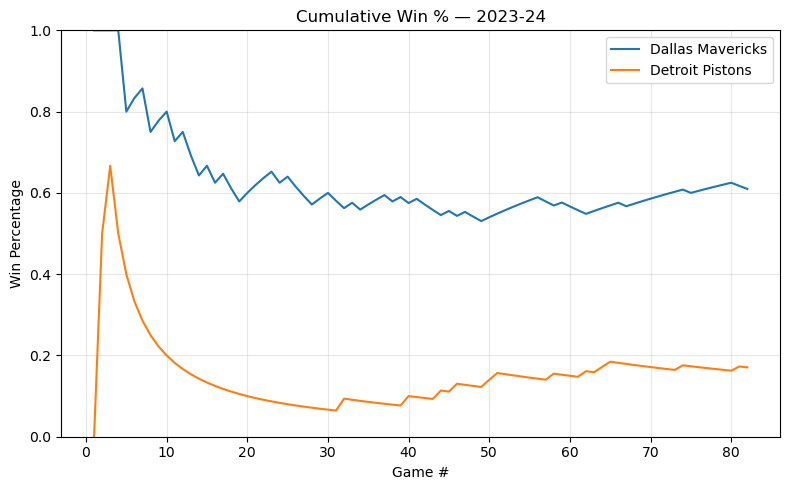

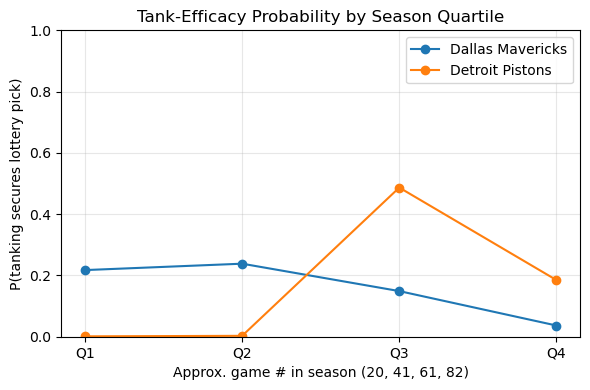

In [21]:
# =====  ONE-SHOT VISUALISATION CELL  =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TARGET_SEASON = "2023-24"
TEAMS = {"DAL": "Dallas Mavericks", "DET": "Detroit Pistons"}

# ------------------------------------------------------------------
# 1) Get per-game win/loss data (from tank_dataset.csv if present)
if Path("tank_dataset.csv").exists():
    tank_df = pd.read_csv("tank_dataset.csv")
    # expand quartiles into rough game # by using the GAMES column
    qsub = tank_df.query("SEASON == @TARGET_SEASON and TEAM_ABR in @TEAMS.keys()")
    # rebuild a pseudo timeline per team (linear interp between quartiles)
    game_curves = {}
    for abr, grp in qsub.groupby("TEAM_ABR"):
        xq = grp["GAMES"].values
        yq = grp["WIN_PCT"].values
        # piece-wise linear interpolation to all 82 games
        x_full = np.arange(1, int(xq.max()) + 1)
        y_full = np.interp(x_full, xq, yq)
        game_curves[abr] = (x_full, y_full)
else:
    # fall back: pull logs live (needs nba_api + internet)
    from nba_api.stats.static import teams
    from nba_api.stats.endpoints import TeamGameLogs
    team_meta = {t["abbreviation"]: t for t in teams.get_teams() if t["abbreviation"] in TEAMS}
    game_curves = {}
    for abr, meta in team_meta.items():
        logs = TeamGameLogs(team_id_nullable=meta["id"],
                            season_nullable=TARGET_SEASON,
                            season_type_nullable="Regular Season").get_data_frames()[0]
        logs["WIN"] = (logs["WL"] == "W").astype(int)
        logs = logs.iloc[::-1]                    # chronological order
        logs["CUM_W"] = logs["WIN"].cumsum()
        logs["WIN_PCT"] = logs["CUM_W"] / np.arange(1, len(logs) + 1)
        game_curves[abr] = (np.arange(1, len(logs)+1), logs["WIN_PCT"].values)

# ------------------------------------------------------------------
# 2) Plot cumulative win-percentage
plt.figure(figsize=(8, 5))
for abr, (x, y) in game_curves.items():
    plt.plot(x, y, label=TEAMS[abr])
plt.title(f"Cumulative Win % — {TARGET_SEASON}")
plt.xlabel("Game #")
plt.ylabel("Win Percentage")
plt.ylim(0, 1)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 3) Progressive tank-efficacy probability (model must be in memory)
try:
    from nba_api.stats.static import teams
    # helper from earlier notebook
    def get_team_id(name):
        return next(t for t in teams.get_teams() if t["full_name"] == name)["id"]

    # build table for plotting
    prob_curves = {}
    for full in TEAMS.values():
        prob_df = prob_by_quartile_progressive(full, TARGET_SEASON)
        prob_curves[full] = (prob_df["Q_FRAC"].values, prob_df["P_TANK_EFFICACY"].values)

    plt.figure(figsize=(6, 4))
    for name, (x, y) in prob_curves.items():
        plt.plot(x*82, y, marker="o", label=name)          # map 0.25→20.5 etc.
    plt.title("Tank-Efficacy Probability by Season Quartile")
    plt.xlabel("Approx. game # in season (20, 41, 61, 82)")
    plt.ylabel("P(tanking secures lottery pick)")
    plt.ylim(0, 1)
    plt.xticks([20.5, 41, 61.5, 82], ["Q1", "Q2", "Q3", "Q4"])
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

except NameError as e:
    print("Model or helper not found in memory. Train the model and define",
          "`prob_by_quartile_progressive` first, then rerun this cell.")
